In [5]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [6]:
sent=nlp('Murat likes apples more than oranges')

In [7]:
for tok in sent:
    print (tok,'.....>',tok.dep_)

Murat .....> nsubj
likes .....> ROOT
apples .....> dobj
more .....> advmod
than .....> prep
oranges .....> pobj


In [8]:
with open('/Users/murat/Downloads/wikisent2.txt', 'r') as file:
    lines = file.readlines()

# Create a DataFrame
df = pd.DataFrame(lines, columns=['Sentence'])

In [9]:
df.head()

,Sentence
0,"0.000123, which corresponds to a distance of 705 Mly, or 216 Mpc.\n"
1,"000webhost is a free web hosting service, operated by Hostinger.\n"
2,"0010x0010 is a Dutch-born audiovisual artist, currently living in Los Angeles.\n"
3,0-0-1-3 is an alcohol abuse prevention program developed in 2004 at Francis E. Warren Air Force Base based on research by the National Institute on Alcohol Abuse and Alcoholism regarding binge dri...
4,"0.01 is the debut studio album of H3llb3nt, released on February 20, 1996 by Fifth Colvmn Records.\n"


In [10]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [11]:
get_entities('Murat has read 200 science books')

['Murat', '200 science books']

In [12]:
df_sample=df.sample(100)

In [14]:
entity_pairs = []

for i in tqdm(df_sample["Sentence"]):
    # print(i)
    entity_pairs.append(get_entities(i))
  

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 170.85it/s]


In [76]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)






    

In [77]:
entity_pairs[5:10]

[['Diaofeng', 'eastern Guangdong Province'],
 ['curling  trials', '14  Arlesheim'],
 ['Cameron', 'Wood County'],
 ['denominmation', 'HanRim Educational Institute'],
 ['before  style', 'still  bass']]

In [78]:
get_relation("John is working on his difficult project very carefully.")

'working on'

In [79]:
relations = [get_relation(i) for i in tqdm(df_sample['Sentence'])]

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 165.50it/s]


In [82]:
pd.DataFrame(relations).value_counts()

0           
is              25
was              7
made             4
referred to      2
released         2
                ..
held             1
included         1
is customary     1
known for        1
were serious     1
Name: count, Length: 61, dtype: int64

In [83]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [90]:
source[:5]

['now  they', 'Niekerk', 'It', 'hospital', 'He']

In [91]:
target[:5]

['Rhodesian Bush War',
 'Dutch Grootegast Groningen',
 'Arista 1985',
 'living family members',
 '2008 baseball Olympics']

In [92]:
kg_df.head()

,source,target,edge
0,now they,Rhodesian Bush War,known for
1,Niekerk,Dutch Grootegast Groningen,is
2,It,Arista 1985,released by
3,hospital,living family members,had
4,He,2008 baseball Olympics,was


In [93]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

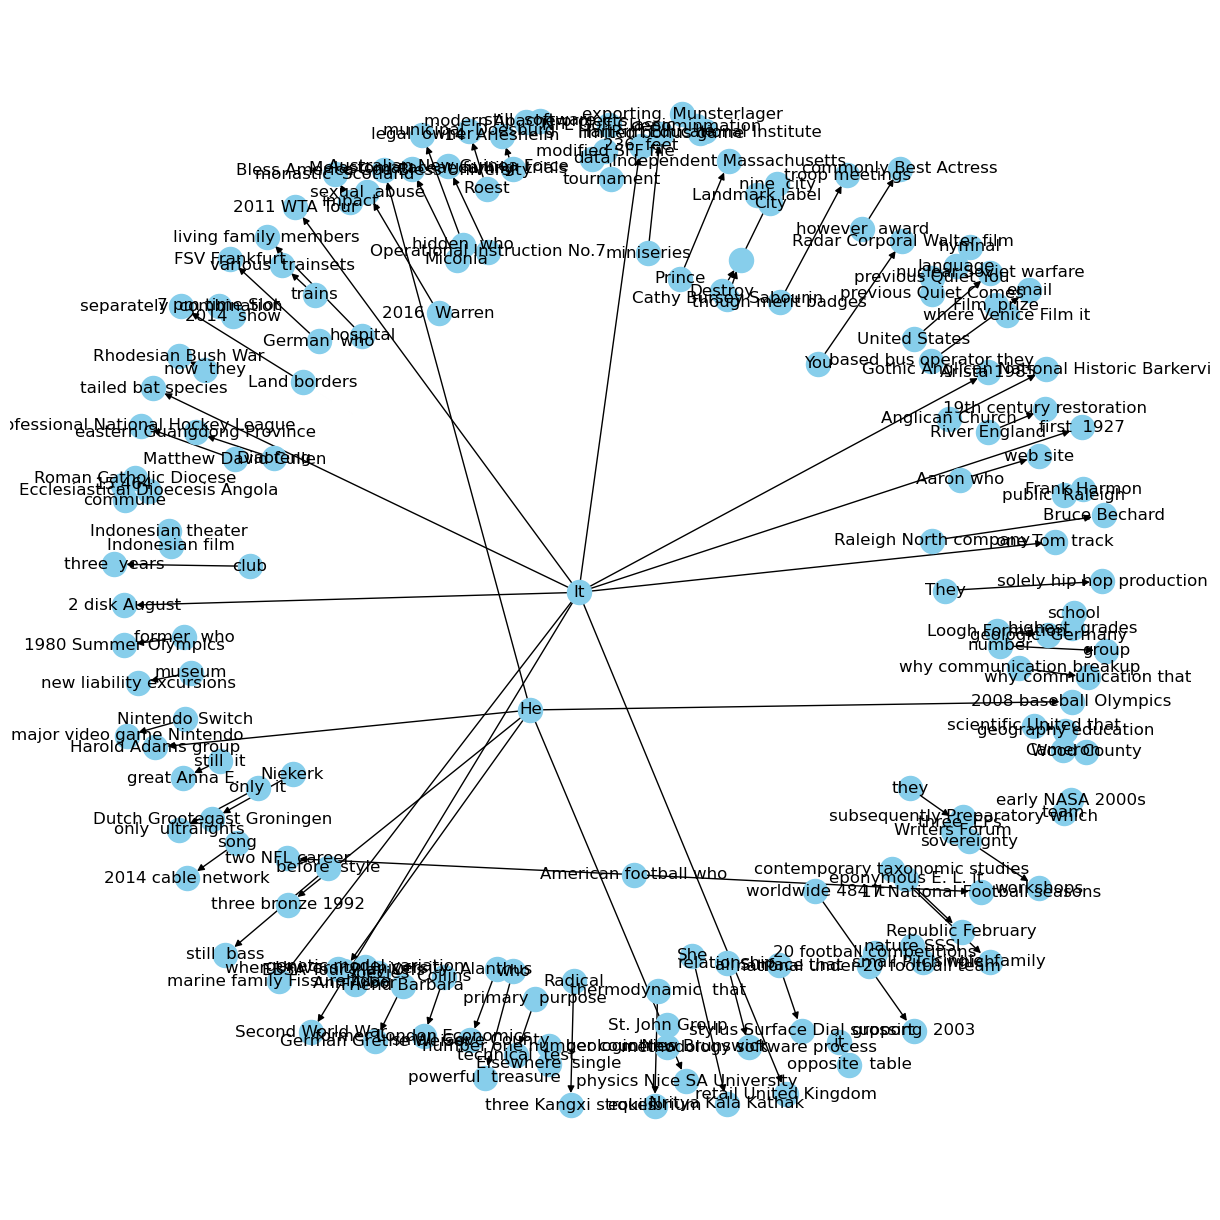

In [94]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

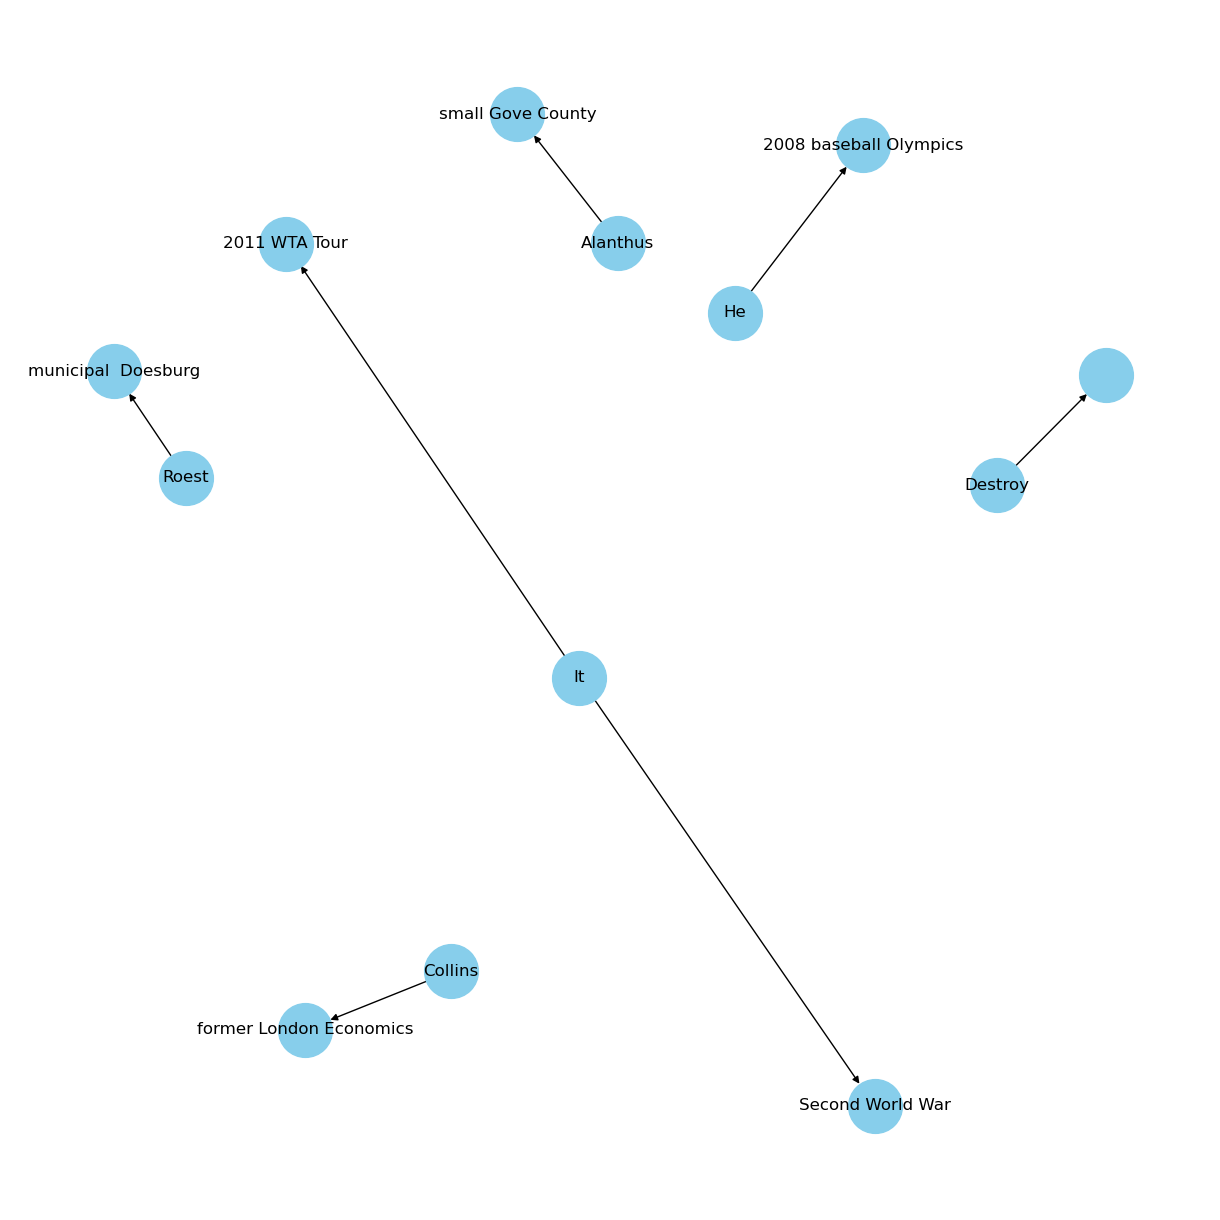

In [97]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="was"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()